In [1]:
%matplotlib inline
from bokeh.io import output_notebook
from bokeh.plotting import *
from matmodlab2 import *
from numpy import *
import numpy as np
output_notebook()
import pandas as pd
import matplotlib.pyplot as plt

Setting up the Matmodlab notebook environment


Loading BokehJS ...

In [2]:
def run_model(B_in, load_dir, load_mags, frames=100):
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    mps1 = MaterialPointSimulator('uplastic-std')
    p = {'E': 10e6, 'Nu': .333, 'Y0': 1e3, "B": B_in}
    mps1.material = ST_GPSR_TTM(**p)
    mps1.run_step(load_dir, load_mags, frames=50)

    return  mps1.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY', 'EP_XX', 'EP_YY', 'EP_ZZ', 'EP_XY', 'EP_YZ', 'EP_XZ', 'EQPS']], mps1

def run_vm(B_in, load_dir, load_mags, frames=100):
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    mps1 = MaterialPointSimulator('uplastic-std')
    p = {'E': 10e6, 'Nu': .333, 'Y0': 1e3, "Y1": 0, "m": 0}
    mps1.material = HardeningPlasticMaterial(**p)
    mps1.run_step(load_dir, load_mags, frames=100)

    return  mps1.df[['S.XX', 'S.YY', 'S.ZZ', 'S.YZ', 'S.XZ', 'S.XY']], mps1

def get_yield_point_princ(df):
    y = df[df.EQPS > 1e-6].iloc[0]
    # Build a stress tensor
    s11 = y['S.XX']
    s22 = y['S.YY']
    s33 = y['S.ZZ']
    s13 = y['S.XZ']
    s23 = y['S.YZ']
    s12 = y['S.XY']
    stress_yield = np.array( [ [ s11, s12, s13], [ s12, s22, s23 ], [ s13, s23, s33 ] ] )
    # stress_dev = stress_yield - 1./3.*np.trace(stress_yield)*np.eye(3)
    # I1 = np.trace(stress_yield)
    # J2 = 1/2*np.tensordot(stress_dev, stress_dev)
    # J3 = np.einsum('ij,jk,ki', stress_dev, stress_dev, stress_dev)/3.
    # r = np.sqrt(2.*J2)
    # theta_s = np.arcsin( J3/2. * (3./J2)**(3./2.) )/3.
    # z = I1/np.sqrt(3)
    # eigval = np.linalg.eigvals(stress_yield)
    
    #print('dev', 'yield', stress_dev, stress_yield)
    return np.array([s11, s22, s33])

def draw_principal_axes(ax, length_of_axes=2.5, scale=100):
    """
    Draws principal axes on graph, change length of axes and scale
    """
    zero_pos = np.zeros(2)
    straight_up_pos = np.array([0, 1]) * length_of_axes
    bottom_right_pos = np.array([np.cos(-np.pi / 6.), np.sin(-np.pi / 6.)]) * length_of_axes
    bottom_left_pos = np.array([np.cos(7 * np.pi / 6.), np.sin(7 * np.pi / 6.)]) * length_of_axes

    ax.quiver(*zero_pos, *straight_up_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_2$", straight_up_pos + np.array([0.25, -0.3]) * scale)

    ax.quiver(*zero_pos, *bottom_right_pos, scale_units="xy", scale=1)
    ax.annotate(r"$\sigma_1$", bottom_right_pos + np.array([-0.18, 0.45]) * scale)

    ax.quiver(*zero_pos, *bottom_left_pos, scale_units="xy", scale=1)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.1, -0.45]) * scale)
    ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([0.28, -0.4]) * scale)
    # ax.annotate(r"$\sigma_3$", bottom_left_pos + np.array([-0.18, -0.4]) * scale)

def align_pi_plane_with_axes_rot():
    """
    Returns a matrix that rotates the pi plane's normal to be the z axis
    i.e., a slice of pi plane becomes the xy plane after rotation
    """
    pi_vector = np.array([1, 1, 1]) / np.sqrt(3.)
    # wanted_vector = np.array([1, 0, 0])
    wanted_vector = np.array([0, 0, 1])
    wanted_vector = wanted_vector / np.linalg.norm(wanted_vector)
    added = (pi_vector + wanted_vector).reshape([-1, 1])

    # from Rodrigues' rotation formula, more info here: https://math.stackexchange.com/a/2672702
    rot_mat = 2 * (added @ added.T) / (added.T @ added) - np.eye(3)
    return rot_mat


def align_axes_with_pi_plane_rot():
    """
    Returns a matrix that undoes the align_pi_plane_with_axes_rot rotation
    """
    return np.linalg.inv(align_pi_plane_with_axes_rot())


angle_pairs = []
for deg in np.linspace(0,2*np.pi,30):
    N = 1E-3
    SH = 1E-3 #np.sqrt(3)*1e3
    x = N*np.cos(deg)
    y = SH*np.sin(deg)
    angle_pairs.append([x,y])
#print(angle_pairs)
pstress = []
for angs in angle_pairs:
    #B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
    B = array( [ [ -0.225, 0.39, 0.23], [-0.093, 0.41, 0.075], [ -0.258, 0.512, 0.139] ])*5.298
    stress, mps = run_model(B, 'EESSSS', (angs[0], angs[1], 0, 0 ,0,0))
    #print(stress)
    #mps.plot('E.XX', 'S.XX')
    prin_stress = get_yield_point_princ(stress)
    pstress.append(prin_stress)
# for angs in angle_pairs:
#     B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
#     stress, mps = run_model(B, 'SSSSSS', (0, angs[0], 0, 0,angs[1],0))
#     #print(stress)
#     #mps.plot('E.XX', 'S.XX')
#     prin_stress = get_yield_point_princ(stress)
#     pstress.append(prin_stress)
# for angs in angle_pairs:
#     B = array([ [ 1, 0, 0], [0, 1, 0 ], [ 0, 0, 1 ] ])
#     stress, mps = run_model(B, 'SSSSSS', (0,0, angs[0], 0,0,angs[1]))
#     #print(stress)
#     #mps.plot('E.XX', 'S.XX')
#     prin_stress = get_yield_point_princ(stress)
#     pstress.append(prin_stress)

print(pstress)


[array([1396.37470211,  458.65987434,    0.        ]), array([ 1.45282883e+03,  7.52697548e+02, -3.97903932e-13]), array([1473.31747732, 1024.05899825,    0.        ]), array([1.45773908e+03, 1.27614083e+03, 1.36424205e-12]), array([1398.42352991, 1516.27415277,    0.        ]), array([1286.25165915, 1724.5075471 ,    0.        ]), array([1.11582404e+03, 1.87893231e+03, 9.09494702e-13]), array([ 7.94090110e+02,  1.96601219e+03, -9.09494702e-13]), array([ 352.8719931, 1867.2372443,    0.       ]), array([ -82.29171785, 1604.5194926 ,    0.        ]), array([-458.16158971, 1258.01730755,    0.        ]), array([-824.12154382,  796.19129748,    0.        ]), array([-1049.89454528,   424.02467528,     0.        ]), array([-1239.13108071,    22.42471773,     0.        ]), array([-1353.96486156,  -303.19214783,     0.        ]), array([-1.42921856e+03, -6.08564984e+02,  5.68434189e-14]), array([-1.46748078e+03, -8.91097013e+02, -9.09494702e-13]), array([-1.47024022e+03, -1.15213736e+03, -2.2

In [3]:
rot = np.array([[-0.78867513,  0.21132487,  0.57735027],
       [ 0.21132487, -0.78867513,  0.57735027],
       [ 0.57735027,  0.57735027,  0.57735027]])
#print(rot)
s1 = []
s2 = []
for eh in pstress:
    vec = eh @ rot
    s1.append(vec[0])
    s2.append(vec[1])

[[ 1.39637470e+03  4.58659874e+02  0.00000000e+00]
 [ 1.45282883e+03  7.52697548e+02 -3.97903932e-13]
 [ 1.47331748e+03  1.02405900e+03  0.00000000e+00]
 [ 1.45773908e+03  1.27614083e+03  1.36424205e-12]
 [ 1.39842353e+03  1.51627415e+03  0.00000000e+00]
 [ 1.28625166e+03  1.72450755e+03  0.00000000e+00]
 [ 1.11582404e+03  1.87893231e+03  9.09494702e-13]
 [ 7.94090110e+02  1.96601219e+03 -9.09494702e-13]
 [ 3.52871993e+02  1.86723724e+03  0.00000000e+00]
 [-8.22917178e+01  1.60451949e+03  0.00000000e+00]
 [-4.58161590e+02  1.25801731e+03  0.00000000e+00]
 [-8.24121544e+02  7.96191297e+02  0.00000000e+00]
 [-1.04989455e+03  4.24024675e+02  0.00000000e+00]
 [-1.23913108e+03  2.24247177e+01  0.00000000e+00]
 [-1.35396486e+03 -3.03192148e+02  0.00000000e+00]
 [-1.42921856e+03 -6.08564984e+02  5.68434189e-14]
 [-1.46748078e+03 -8.91097013e+02 -9.09494702e-13]
 [-1.47024022e+03 -1.15213736e+03 -2.27373675e-13]
 [-1.43460814e+03 -1.39711546e+03  0.00000000e+00]
 [-1.35260613e+03 -1.61967116e+

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\brian\AppData\Local\Temp\ipykernel_1924\2582416723.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma_{11}/Y_0$')
C:\Users\brian\AppData\Local\Temp\ipykernel_1924\2582416723.py:5: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{22}/Y_0$')


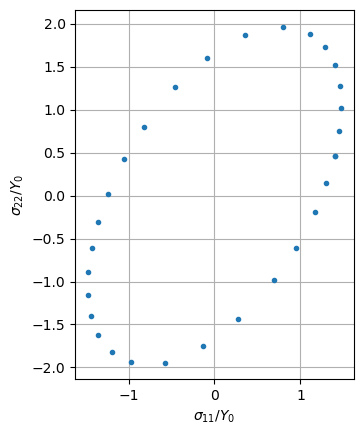

In [4]:
pstress = np.array(pstress)
print(pstress)
plt.plot(pstress[:,0]/1e3, pstress[:,1]/1e3, '.')
plt.xlabel('$\sigma_{11}/Y_0$')
plt.ylabel('$\sigma_{22}/Y_0$')
plt.grid()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')